In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Input 3 numpy arrays (a, b, f) size of N:
# y[i-1] + a[i] * y[i] + b[i] * y[i+1] = f[i], where i = [1, N]
#
# Note: a[0], b[0] - unusable
def SolveSweepMethod (a, b, f, y_0, y_N):
    N = a.size

    # First sweep
    a_, f_ = np.zeros (N), np.zeros (N)
    f_[0] = y_0
    for i in range (1, N):
        z = a[i] + a_[i - 1]
        a_[i] = -b[i] / z
        f_[i] = (f[i] - f_[i - 1]) / z
    
    # Second sweep
    y = np.zeros (N + 1)
    y[0], y[N] = y_0, y_N
    for i in range (N - 1, 0, -1):
        y[i] = a_[i] * y[i+1] + f_[i]

    return y

def linearize (X, Y):
  A = np.vstack ([X, np.ones (X.size)]).T
  k, b = np.linalg.lstsq (A, Y, rcond=None)[0]

  return k, b

def printErrorPower (h_arr, err_arr):
    k, b = linearize (np.log (h_arr), np.log (err_arr))
    print (f"Error O(h^{abs(k):0.2})")

def plotSolveAndAnswer (solve_x, solve_y, answer_x, answer_y, dpi=100):
    plt.figure (dpi=dpi)
    plt.xlabel ('y(x)')
    plt.ylabel ('x')
    plt.plot (solve_x, solve_y, label='solve', linewidth=3)
    plt.legend ()
    plt.plot (answer_x, answer_y, label='answer', linestyle='-.', linewidth=1)
    plt.legend ()

def plotError (h_arr, err_arr, dpi=100):
    plt.figure (dpi=dpi)
    plt.title ('lg(err (lg (h)))')
    plt.xlabel ('lg (h)')
    plt.ylabel ('lg (err)')
    plt.plot (np.log10 (h_arr), np.log10 (err_arr))

## Уравнение теплопроводности, $\sigma\in(0,1]$


In [20]:
def solve_heat_equation_sigma (sigma, x_arr, t_arr, f, u_x_0_arr, u_t_a_arr, u_t_b_arr):
    h = x_arr[1] - x_arr[0]
    dt = t_arr[1] - t_arr[0]

    N_t = t_arr.size
    N_x = x_arr.size
    u = np.zeros ([N_t, N_x])
    u[0] = u_x_0_arr

    for j in range (1, N_t):
        a, b, phi = np.zeros (N_x-1), np.zeros (N_x-1), np.zeros (N_x-1)
        C = h * h / (sigma * dt)
        for i in range (1, N_x-1):
            a[i] = -2 - C
            b[i] = 1
            phi[i] = -((1/sigma - 1) * (u[j-1][i+1] - 2 * u[j-1][i] + u[j-1][i-1]) +
                      + C * (u[j-1][i] + f (t_arr[j], x_arr[i]) * dt))
            
        u[j] = SolveSweepMethod (a, b, phi, u_t_a_arr[j], u_t_b_arr[j])
    
    return u

# Пример

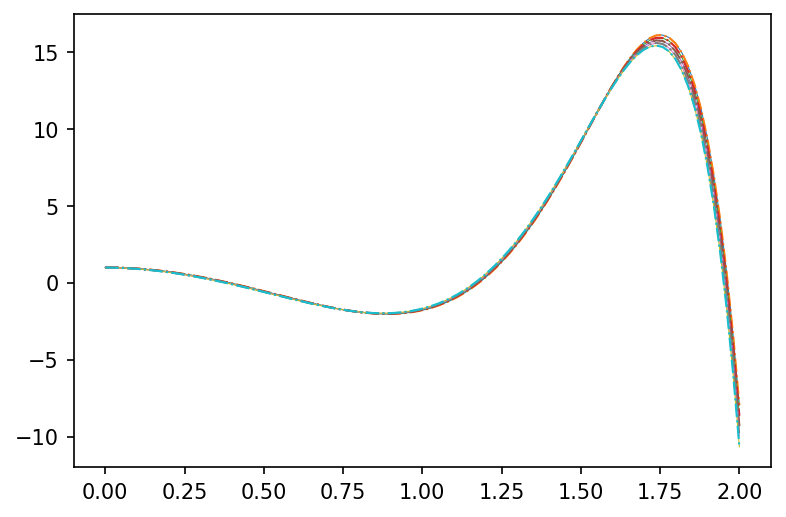

In [28]:
a, b = 0, 2
ref_f_solve = lambda t, x: np.cos (4 * x + t) * np.exp (x * x)

u_x_0 = lambda x: ref_f_solve (0, x)
u_t_a = lambda t: ref_f_solve (t, a)
u_t_b = lambda t: ref_f_solve (t, b)

def f (t, x):
    g = 4 * x + t
    tmp = (16 * x - 1) * np.sin (g) + (14 - 4 * x * x) * np.cos (g)
    return np.exp (x*x) * tmp

t_min, t_max = 0, np.pi/50
N_x = 100   # 100
N_t = 500   # 500
N_graph = N_t // 5

x_arr = np.linspace (a, b, N_x)
t_arr = np.linspace (t_min, t_max, N_t)
u_ref = np.array ([ref_f_solve (t, x_arr) for t in t_arr])

u_x_0_arr = u_x_0 (x_arr)
u_t_a_arr = u_t_a (t_arr)
u_t_b_arr = u_t_b (t_arr)

u = solve_heat_equation_sigma (0.8, x_arr, t_arr, f, u_x_0_arr, u_t_a_arr, u_t_b_arr)

plt.figure (dpi=150)
for j in range (N_t):
    if j % N_graph == 0:
        plt.plot (x_arr, u[j], linewidth=0.5)
        plt.plot (x_arr, u_ref[j], '-.', linewidth=1)

Error O(h^2.1)


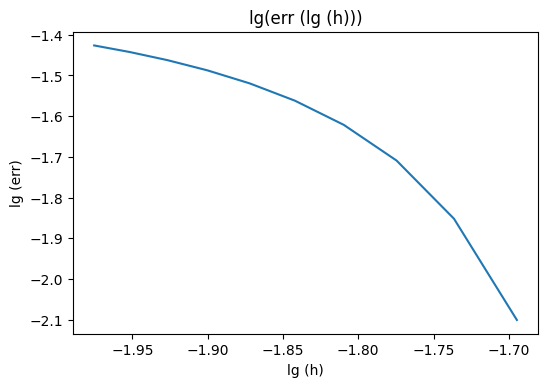

In [22]:
def calc_error_sigma (sigma):
    num_points = 10

    err_x_arr, dx_arr = np.zeros (num_points), np.zeros (num_points)
    err_t_arr, dt_arr = np.zeros (num_points), np.zeros (num_points)

    # x error
    dN_x = N_x // 10
    N_x_ = N_x
    for i in range (num_points):
        x_arr = np.linspace (a, b, N_x_)
        t_arr = np.linspace (t_min, t_max, N_t)
        u_ref = np.array ([ref_f_solve (t, x_arr) for t in t_arr])

        u_x_0_arr = u_x_0 (x_arr)
        u_t_a_arr = u_t_a (t_arr)
        u_t_b_arr = u_t_b (t_arr)
        u = solve_heat_equation_sigma (sigma, x_arr, t_arr, f, u_x_0_arr, u_t_a_arr, u_t_b_arr)

        err_x_arr[i] = np.max (np.abs (u - u_ref))
        dx_arr[i] = x_arr[1] - x_arr[0]

        N_x_ = N_x_ + dN_x

    # t error
    # dN_t = N_t // 10
    # N_t_ = N_t
    # for i in range (num_points):
    #     x_arr = np.linspace (a, b, N_x)
    #     t_arr = np.linspace (t_min, t_max, N_t_)
    #     u_ref = np.array ([ref_f_solve (t, x_arr) for t in t_arr])

    #     u_x_0_arr = u_x_0 (x_arr)
    #     u_t_a_arr = u_t_a (t_arr)
    #     u_t_b_arr = u_t_b (t_arr)
    #     u = solve_heat_equation_sigma (sigma, x_arr, t_arr, f, u_x_0_arr, u_t_a_arr, u_t_b_arr)

    #     err_t_arr[i] = np.max (np.abs (u - u_ref))
    #     dt_arr[i] = t_arr[1] - t_arr[0]

    #     N_t_ = N_t_ + dN_t

    return dx_arr, err_x_arr, dt_arr, err_t_arr

dx_arr, err_x_arr, dt_arr, err_t_arr = calc_error_sigma (0.8)

plotError (dx_arr, err_x_arr)
# plotError (dt_arr, err_t_arr)

printErrorPower (dx_arr, err_x_arr)
# print (err_t_arr)
# printErrorPower (dt_arr, err_t_arr)

## Уравнение теплопроводности, $\sigma=\sigma^*$


In [ ]:
def solve_heat_equation_sigma_star (x_arr, t_arr, f, u_x_0_arr, u_t_a_arr, u_t_b_arr):
    h = x_arr[1] - x_arr[0]
    dt = t_arr[1] - t_arr[0]
    sigma = 0.5 - h * h / (12 * dt)

    N_x = x_arr.size
    N_t = t_arr.size
    u = np.zeros ([N_t, N_x])
    u[0] = u_x_0_arr

    for j in range (1, N_t):
        a, b, phi = np.zeros (N_x-1), np.zeros (N_x-1), np.zeros (N_x-1)
        C = h * h / (sigma * dt)
        for i in range (1, N_x-1):
            a[i] = -2 - C
            b[i] = 1

            t = t_arr[j] + dt/2
            x = x_arr[i]
            fxx = (f (t, x + h) - 2 * f (t, x) + f (t, x - h))
            f_cur = f (t, x) + fxx / 12

            phi[i] = -((1/sigma - 1) * (u[j-1][i+1] - 2 * u[j-1][i] + u[j-1][i-1]) +
                      + C * (u[j-1][i] + f_cur * dt))
            
        u[j] = SolveSweepMethod (a, b, phi, u_t_a_arr[j], u_t_b_arr[j])

    return u

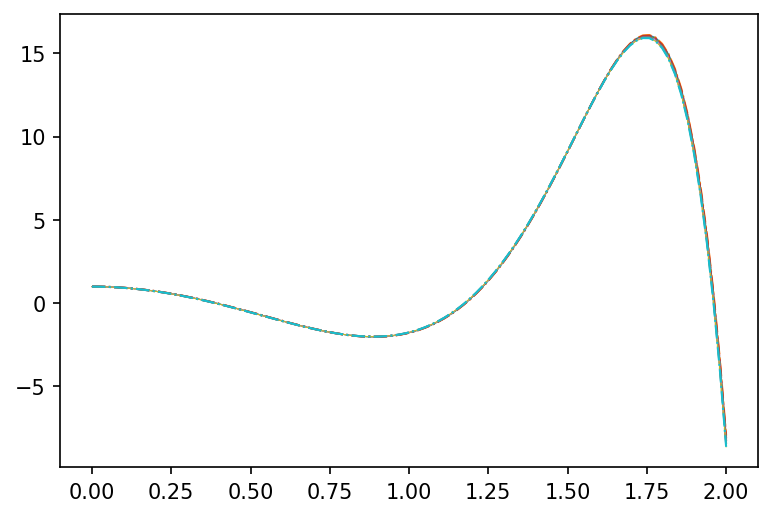

In [ ]:
u = solve_heat_equation_sigma_star (x_arr, t_arr, f, u_x_0_arr, u_t_a_arr, u_t_b_arr)

plt.figure (dpi=150)
for j in range (N_t):
    if j % N_graph == 0:
        plt.plot (x_arr, u[j], linewidth=0.5)
        plt.plot (x_arr, u_ref[j], '-.', linewidth=1)

Error O(h^4.1)


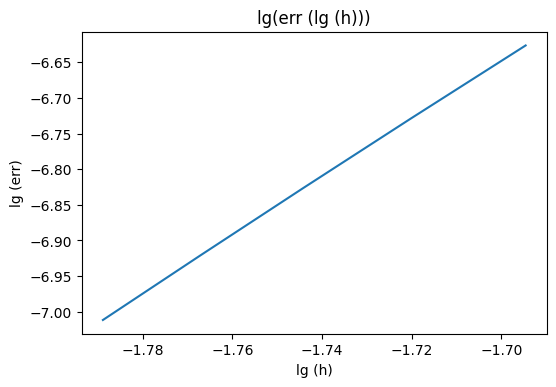

In [ ]:
def calc_error_sigma_star ():
    num_points = 5

    err_x_arr, dx_arr = np.zeros (num_points), np.zeros (num_points)
    err_t_arr, dt_arr = np.zeros (num_points), np.zeros (num_points)

    # x error
    dN_x = N_x // 15
    N_x_ = N_x // 1
    for i in range (num_points):
        x_arr = np.linspace (a, b, N_x_)
        t_arr = np.linspace (t_min, t_max / 50, N_t)
        u_ref = np.array ([ref_f_solve (t, x_arr) for t in t_arr])

        u_x_0_arr = u_x_0 (x_arr)
        u_t_a_arr = u_t_a (t_arr)
        u_t_b_arr = u_t_b (t_arr)
        u = solve_heat_equation_sigma_star (x_arr, t_arr, f, u_x_0_arr, u_t_a_arr, u_t_b_arr)

        err_x_arr[i] = np.max (np.abs (u - u_ref))
        dx_arr[i] = x_arr[1] - x_arr[0]

        N_x_ = N_x_ + dN_x

    # t error
    # dN_t = N_t // 10
    # N_t_ = N_t
    # for i in range (num_points):
    #     x_arr = np.linspace (a, b, N_x)
    #     t_arr = np.linspace (t_min, 2 * t_max, N_t_)
    #     u_ref = np.array ([ref_f_solve (t, x_arr) for t in t_arr])

    #     u_x_0_arr = u_x_0 (x_arr)
    #     u_t_a_arr = u_t_a (t_arr)
    #     u_t_b_arr = u_t_b (t_arr)
    #     u = solve_heat_equation_sigma_star (x_arr, t_arr, f, u_x_0_arr, u_t_a_arr, u_t_b_arr)

    #     err_t_arr[i] = np.max (np.abs (u - u_ref))
    #     dt_arr[i] = t_arr[1] - t_arr[0]

    #     N_t_ = N_t_ + dN_t

    return dx_arr, err_x_arr, dt_arr, err_t_arr

dx_arr, err_x_arr, dt_arr, err_t_arr = calc_error_sigma_star ()

plotError (dx_arr, err_x_arr)
# plotError (dt_arr, err_t_arr)

printErrorPower (dx_arr, err_x_arr)
# print (err_t_arr)
# printErrorPower (dt_arr, err_t_arr)